# MIE 1624: Introduction to Data Science and Analytics

## Assignment 2 - Sentiment Analysis

### Bowen Xu

# Import all Libraries

In [79]:
import pandas as pd
import numpy as np

import nltk
import html
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
import re
import unicodedata
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from statistics import mean
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

[nltk_data] Downloading package stopwords to /Users/barry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/barry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data Cleaning

## Sentiment.csv

In [40]:
df_sentiment = pd.read_csv('Sentiment.csv')
df_sentiment

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...
...,...,...
133806,Positive,"@scottw Nice, I have the 20/20 but to be hones..."
133807,Positive,â€œ@BW_React: #GOPDebate verdict: @JohnKasich ...
133808,Negative,@amtrack i am sorry .... i love you tho and t...
133809,Positive,@RazorTV http://tinyurl.com/d96txo - Champions...


### Clean Data

The data cleaning procedure for the tweets is listed below with explanations:
   1. **Remove Usernames:** Some tweets include 'RT @' at the beginning which means the user is re-tweeting the tweet that belongs tp someone else, I converted it to single '@' for convenience and then remove all usernames after '@' symbol since the usernames are not important or not meaningful for sentiment analysis.
   2. **Remove Emoji:** In twitter, people tend to use emojis very frequently and they are converted to unicode in text, therefore, I used regular expression to remove those emojis since they are have similar format like 'x..'.
   3. **Remove html tags and attributes:**  BeautifulSoup function is used for this task, I used 'html.parser' since the speed anf accuracy for this task is pretty decent.
   4. **HTML character codes:**  The unicode characters in the tweets are normalized by 'NFKD' which means the normal form will apply the compatibility decomposition, i.e. replace all compatibility characters with their equivalents. Then, transfer to ASCII equivalent and decode into normal strings again.
   5. **Remove URLs:** Using regular expression for url format to remove it.
   6. **Convert to lowercase:** Simply convert the strings to lowercase.
   7. **Manipulate text:**  This task is very important but complicated. Firstly, each tweet is tokenized into a list of words by using regexptokenizer, then select those words that are not in stopword and finally lemmatize the word to remove its root (some words may have same meaning but different forms such authorized and authority, by using lemmatizer, it can eliminate some repeated words to save space and computational time).

In [41]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [42]:
for i in range(len(df_sentiment)):

    text = df_sentiment['text'][i]

    # convert 'RT @'' to '@' and Remove the word after @
    rt = re.compile('RT @')
    text = re.sub(rt, '@', str(text))
    at = re.compile('@(?=\w+)\w+')
    text = re.sub(at,'', str(text))
    
    #remove emoji
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    
    #remove html tags and attributes
    text = BeautifulSoup(text,'html.parser').get_text()
    
    #replace ASCII
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')

    #remove URLs
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    #lowercase
    text = text.lower()

    #remove stop words and lemmatize words
    text = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]

    #assign new strings
    df_sentiment['text'][i] = text

In [43]:
df_sentiment

,sentiment,text
0,Positive,"[tried, take, poll, number, skyrocketed, voter..."
1,Negative,"[damn, jealous, wanna, watch, fight, love, ufc..."
2,Positive,"[listening, beatles, great]"
3,Positive,"[could, please, get, shout, anything, huge, fa..."
4,Positive,"[spotted, ur, message, tony, replied]"
...,...,...
133806,Positive,"[nice, 20, 20, honest, think, really, need, 20..."
133807,Positive,"[gopdebate, verdict, win, 74, 5, positive, sen..."
133808,Negative,"[sorry, love, tho, thats, matter, hahahaha]"
133809,Positive,"[champion, league, 25, free, bet]"


## Canadian_elections_2019.csv

For election dataset, I used very similar methods as before. The only difference here is that I removed some meaningless symbols like 'b' at the beginning of every tweet and '\\\n' in some tweets. Furthermore, some tweets in this section have many emojis, I used regular expression to remove those character since all emojis are encoded into 'x..' format.

In [44]:
df_election = pd.read_csv('Canadian_elections_2019.csv')
df_election

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."
...,...,...,...
2128,Negative,Scandal,b'You know he was doing a good enough job smea...
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...


In [45]:
for i in range(len(df_election)):

    text = df_election['text'][i]
    
    #remove unknown characters b and \\n
    text = text.replace('\\n','')
    text = re.sub(r'[b]\"|[b]\'', '', text)
    
    #remove emoji
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    
    # Remove the word after @
    text = re.compile('RT @').sub('@', str(text))
    at = re.compile('@(?=\w+)\w+')
    text = re.sub(at,'', str(text))
    
    #remove html tags and attributes
    text = BeautifulSoup(text,'html.parser').get_text()

    #replace ASCII
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')

    #remove URLs
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    #lowercase
    text = text.lower()

    #remove stop words
    text = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]

    #assign new strings
    df_election['text'][i] = text

In [46]:
df_election

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ..."
1,Positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city..."
2,Negative,Economy,"[brantford, going, cost, 94, billion, next, 4,..."
3,Positive,NaN,"[canada, canadaelection2019, canadavotes, elxn..."
4,Negative,Economy,"[canada, taxpayer, sick, tired, hard, earned, ..."
...,...,...,...
2128,Negative,Scandal,"[know, good, enough, job, smearing, campaign, ..."
2129,Negative,Scandal,"[missed, comment, deflecting, issue, answer, b..."
2130,Positive,NaN,"[daily, reminder, endorses, strategic, voting,..."
2131,Negative,Women Reproductive right and Racism,"[yup, going, reopen, abortion, debate, elxn43,..."


# 2. Exploratory Analysis

## Label Political Parties

Relevant Information for Different Politocal Parties:
1. **Liberal**
    - Leader: Justin Trudeau
    - Twitter Account: @JustinTrudeau
    - Slogan: 'chooseforward'
    - Hashtag: #lpc
    
2. **Conservative**
    - Leader: Andrew Scheer
    - Twitter Account: @AndrewScheer
    - Slogan: 'it's time for your to get ahead'
    - Hashtag: #cpc

3. **New Democratic**
    - Leader: Jagmeet Singh
    - Twitter Account: @theJagmeetSingh
    - Slogan: 'in it for you'
    - Hashtag: #ndp

4. **None**
    - Includes Bloc Quebecois and Green parties

#### Procedures:

I built a simple function that take every cleaned text (list of words) as argument, this function has three major components:

1. According to the keywords for different parties, I created three lists for three major parties which each contains different combinations of keywords that people may mention in their tweets (these keywords are generated based on web search and commnon-knowledge as well);

2. For every word in the text, to see whether the keywords in the created lists are shown in the text, if so, append the corresponding party or parties;

3. There may be more than one parties mentioned, if so: the most common parties mentioned will be selected; or no party mentioned at all in a tweet: 'None' will be applied.

The justification is: usually mentioned words can directly express the information of supported party for each tweet, the party names and leaders mentioned are either in short form or complete form. However, this method may induce bias or mislabel to the tweets since some tweets may not include these words but express its choice, this may decrease the accuracy of model.

In [47]:
def party_label(text):
    
    #define which key words indicate which party
    c_words = ['conservatives', 'cpc','andrew','scheer','andrewscheer','conservative','voteconservative','getahead']
    l_words = ['trudeau', "justin", "justintrudeau", "liberal","liberals","red","teamtrudeau","lpc",'voteliberal','chooseforward']
    n_words = ['new democratic party','ndp','ptndp','thejagmeet','jagmeet','singh','jagmeetsingh','democratic','democrats','initforyou']
    mentioned_parties = []
  
    #if found, add the party to mentioned party list
    for word in text:
        if word in c_words:
              mentioned_parties.append('conservatives')
        if word in l_words:
              mentioned_parties.append('liberal')
        if word in n_words:
              mentioned_parties.append('new democratic party')
                
    # Find the most common party mentioned 
    # If nothing, return None
    if len(mentioned_parties) > 1:
        most_common = max(set(mentioned_parties), key=mentioned_parties.count)
        mentioned_parties = []
        mentioned_parties.append(most_common)
            
    elif len(mentioned_parties) == 0:
        mentioned_parties.append('None')
    
    return mentioned_parties[0] #return value rather than list

In [48]:
# add column of party
df_election['political_party'] = ''
df_election

,sentiment,negative_reason,text,political_party
0,Negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",
1,Positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",
2,Negative,Economy,"[brantford, going, cost, 94, billion, next, 4,...",
3,Positive,NaN,"[canada, canadaelection2019, canadavotes, elxn...",
4,Negative,Economy,"[canada, taxpayer, sick, tired, hard, earned, ...",
...,...,...,...,...
2128,Negative,Scandal,"[know, good, enough, job, smearing, campaign, ...",
2129,Negative,Scandal,"[missed, comment, deflecting, issue, answer, b...",
2130,Positive,NaN,"[daily, reminder, endorses, strategic, voting,...",
2131,Negative,Women Reproductive right and Racism,"[yup, going, reopen, abortion, debate, elxn43,...",


In [49]:
#call the function to assgin labels
for i in range(len(df_election)):
    df_election['political_party'][i] = party_label(df_election['text'][i])

In [50]:
df_election

,sentiment,negative_reason,text,political_party
0,Negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",conservatives
1,Positive,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",None
2,Negative,Economy,"[brantford, going, cost, 94, billion, next, 4,...",liberal
3,Positive,NaN,"[canada, canadaelection2019, canadavotes, elxn...",None
4,Negative,Economy,"[canada, taxpayer, sick, tired, hard, earned, ...",None
...,...,...,...,...
2128,Negative,Scandal,"[know, good, enough, job, smearing, campaign, ...",None
2129,Negative,Scandal,"[missed, comment, deflecting, issue, answer, b...",None
2130,Positive,NaN,"[daily, reminder, endorses, strategic, voting,...",liberal
2131,Negative,Women Reproductive right and Racism,"[yup, going, reopen, abortion, debate, elxn43,...",None


## Plot Distribution of Political Parties

**None**

By observing the count of different parties, we can see more than half of the tweets are classified as 'None', and conservative party and liberal party have very similar counts and NDP has the fewest counts among all other parties. The reason behind is that 'None' includes other parties are not mentioned in this classification problem such as Green and Bloc Quebecois parties, futhermore, some tweets that are irrelevant to the election are also included in the 'None' group, also some tweets with implied meanings (those may not directly mention the parties he/she supports but has an implication to that party) are also in.

**Libral and Conservative**

Libral and Conservative parties are two most popular parties in 2019 election since these two parties occupied the majority of seats in the House of Commons, it also indicates that these two parties have very similar number of supportors on Twitter.

**NDP**

NDP has the smallest number of counts in the tweets which means the NDP may have the fewest number of supportors in both House of Common and Twitter which complies with reality (election result is: Libral has 184 seats, conservative has 99 seats and NDP has 44 seat only)(NDP only get 19.71% of votes)

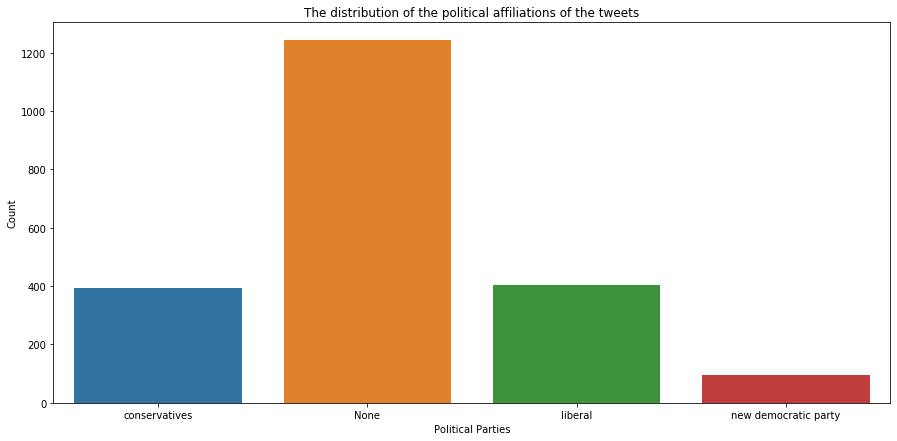

In [51]:
# Plot distribution for each party
plt.figure(figsize=(15,7))
ax = sns.countplot(x='political_party',data=df_election)
ax.axes.set_title('The distribution of the political affiliations of the tweets')
ax.set_xlabel('Political Parties')
ax.set_ylabel('Count')
plt.show()

## Sentiment Plots

### Positive vs. Negative in Different Parties

By plotting the distribution of all sentiment categories, we can see there are three types of sentiment: positive, negative and neutral. 'Neutral' sentiment does not provide any useful information for models to classify positive and negative sentiments, therefore, this category could be dropped in the model implementation. Positive and negative sentiments are distributed fairly similar, the dataset is not imbalanced and not biased to one of the categories.

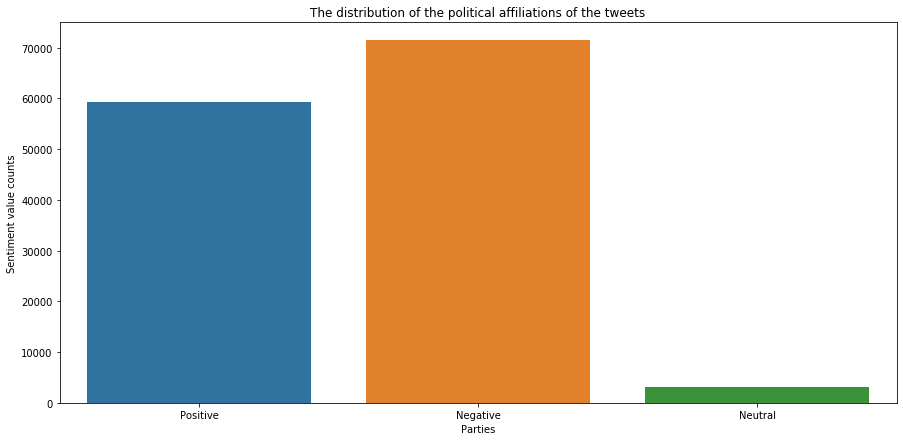

In [52]:
# Plot distribution of tweets with sentiment values for each party
plt.figure(figsize=(15,7))
ax = sns.countplot(x='sentiment', data=df_sentiment)
ax.axes.set_title('The distribution of the political affiliations of the tweets')
ax.set_xlabel('Parties')
ax.set_ylabel('Sentiment value counts')
plt.show()

### Bonus
### Wordcloud on Positive Sentiment only (sentiment.csv)

Positive sentiments have many good words to express their feelings such as good, awesome, well, great and love. This means the user is expressing his/her positive feelings in the tweets. These words will help the model to decide the sentiment of twitters.

In [53]:
# Transform list of string into a master string to pass into wordcloud
df_positive = df_sentiment[df_sentiment['sentiment'] == 'Positive']
positive = ''
for line in df_positive['text']:
    for word in line:
        positive = positive + word + " "

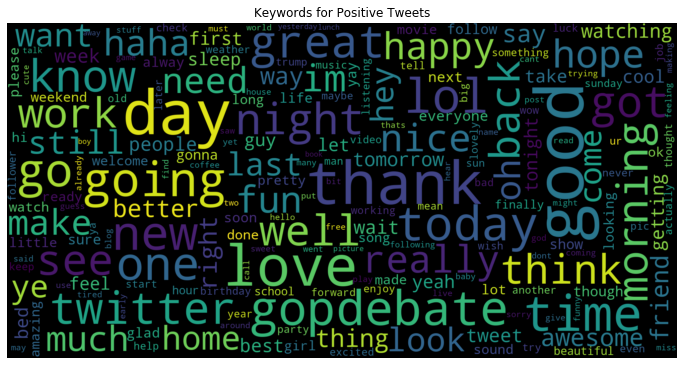

In [54]:
# Generate the wordcloud 
wordcloud = WordCloud(width=2000, height=1000,max_font_size=200,collocations=False).generate(positive)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Keywords for Positive Tweets')
plt.axis("off")
plt.show()

## Election Plots

### Nagative Reason Distribution for election dataset

From the pie-char below, excluding 'others' category, we can see 'scandal' and 'tell lies' occupied large proportions(almost 50%) over the entire negative sentiment dataset, which are two properties a good party leader should not have and people tend to be very judgeable on these two properties. Other reasons such as 'economy', 'climate change' and 'woman reproductive right and racism' all have very similar proportions which indicate that people also concerns with these political issues or hot content among these years. The distribution of these negative reasons are not balanced, therefore, it needs to be carefully engineered to prevent bias in prediction in later model implementation.

In [55]:
df_election['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [56]:
# Obtain negative reasons
neg_reasons = df_election['negative_reason'].tolist()
# Remove Nans
neg_reasons = [x for x in neg_reasons if str(x) != 'nan']
neg_count = Counter(neg_reasons)

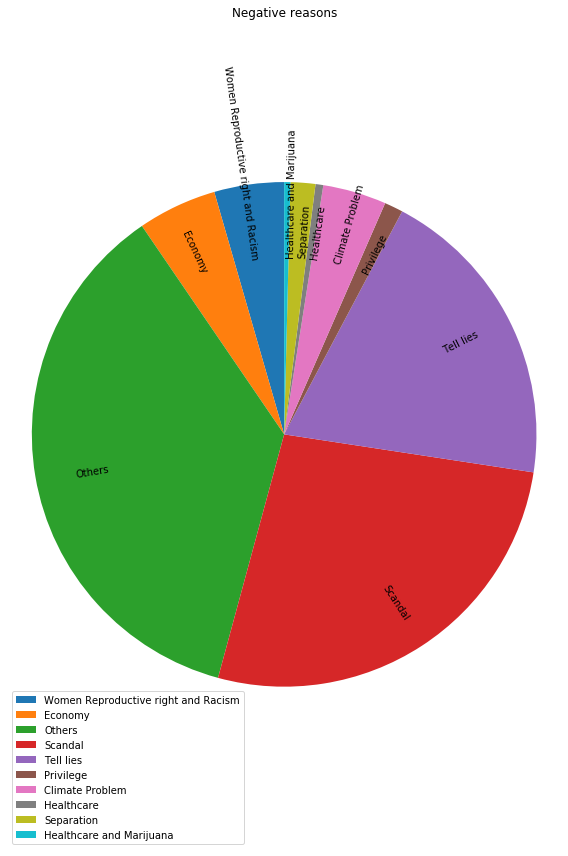

In [75]:
fig, ax = plt.subplots(figsize=[8, 12])
# Use reasons and its freqency to draw the pie chart
ax.pie(neg_count.values(), labels=neg_count.keys(), rotatelabels =True,labeldistance =0.7,pctdistance=0.8,
        startangle=90)
ax.axis('equal')  
ax.set_title('Negative reasons')
plt.legend(loc="lower left")
fig.tight_layout()
plt.show()

### Bonus
### Wordcloud on Liberal Party Positive Only

Liberal party, as the winner party in 2019 election, it is interesting to look at those positive comments from supportors. As we can see from the wordcloud in all positive twitters, the key terms which include the slogan('chooseforward') and leader of Liberal party('trudeau') are very related to the elections, however, keywords such as 'elxn43' and 'cdnpoli' are not providing any useful information and may have induce noises to the model and hace bad influence on the predictions later.

In [58]:
# Transform list of string into a master string to pass into wordcloud
lib = df_election[df_election['political_party'] == 'liberal']
lib_positive = lib[lib['sentiment'] == 'Positive']
positive_lib_str = ''
for line in lib_positive['text']:
    for word in line:
        positive_lib_str = positive_lib_str + word + " "

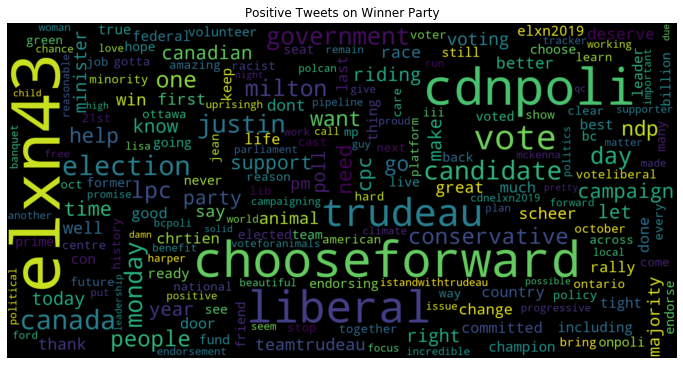

In [59]:
# Generate the wordcloud 
wordcloud = WordCloud(width=2000, height=1000,max_font_size=200,collocations=False).generate(positive_lib_str)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Positive Tweets on Winner Party')
plt.show()

# 3. Model Preparation

- This section includes the train-test set preparation, feature generation and the model implementation for the sentiment.csv only. The training and testing set are splited into 70% of training and 30% of testing, and two different types of vectorization approaches: Bag of Words and TF-IDF, are applied to extract the numeric features out of the text data for the model implementation (regard each word as a feature).

- Multiple classification algorithms, including logistic regression, k-NN, Naive Bayes,SVM, decision trees,and ensembles (Ransom Forest), are used to train the dataset, and the accuracy and performance of each algorithm are summarized after each model implementation.

### Drop 'Neutral' Sentiment

The target variables will only include positive or negative values

In [60]:
df_sentiment['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [61]:
df = df_sentiment[df_sentiment['sentiment'] != 'Neutral']

### LabelEncoding Targets

In [62]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

/Users/barry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
df.index = range(len(df))
df

,sentiment,text
0,1,"[tried, take, poll, number, skyrocketed, voter..."
1,0,"[damn, jealous, wanna, watch, fight, love, ufc..."
2,1,"[listening, beatles, great]"
3,1,"[could, please, get, shout, anything, huge, fa..."
4,1,"[spotted, ur, message, tony, replied]"
...,...,...
130664,1,"[nice, 20, 20, honest, think, really, need, 20..."
130665,1,"[gopdebate, verdict, win, 74, 5, positive, sen..."
130666,0,"[sorry, love, tho, thats, matter, hahahaha]"
130667,1,"[champion, league, 25, free, bet]"


### Word Frequency

For a text classification problem, a vectorization process is required to transform the text data into numerical data for the model implementation. Two vectorization approaches are applied here, Word Frequency and Term Frequency-Inverse Document Frequency, and each approach generates a numerical feature based on the cleaned text.

Word Frequency approach uses the frequency of a word appearance as the numerical feature and converts the collection of text documents to a sparse matrix of token counts. The CountVectorizer function from the sklearn library will be used to extract the word frequency feature; before that, a string of words is required to count word as an argument to count the frequency.

In [64]:
df['text'] = df['text'].apply(lambda x: ' '.join(map(str, x)))
df

/Users/barry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sentiment,text
0,1,tried take poll number skyrocketed voter matte...
1,0,damn jealous wanna watch fight love ufc one know
2,1,listening beatles great
3,1,could please get shout anything huge fan wait ...
4,1,spotted ur message tony replied
...,...,...
130664,1,nice 20 20 honest think really need 20 unless ...
130665,1,gopdebate verdict win 74 5 positive sentiment
130666,0,sorry love tho thats matter hahahaha
130667,1,champion league 25 free bet


In [65]:
# Bag of Words model
# Only transforming sentiment_tweets data here
vec_bw = CountVectorizer()
array_WF = vec_bw.fit_transform(df['text'])

In [66]:
array_WF.shape

(130669, 57212)

In [67]:
#Split into train and test dataset
Xwf_train, Xwf_test, ywf_train, ywf_test = train_test_split(array_WF, df['sentiment'],test_size=0.3,stratify=df['sentiment'])

### TF-IDF

TF stands for term frequency and it is calculated as the number of times a term appears in a document divided by the total number of words of the document. The normalization mitigates the bias caused by the different document length.

IDF stands for inverse ducument frequency and it reveals how rare a term is across the entire corpus.

The product of TF and IDF gives us the result of weightings of each word.

Term Frequency-Inverse Document Frequency is a statistical measure for the importance of a word to the corpus. The importance increases proportionally to the number of times a word appears in the document but decreases with increasing number of documents which contain the word. For example, stopwords have high frequency in a document obviously but they are meaningless for useful information, therefore, document frequency can help decrease the weightings on the stopwords since it decreases as more documents contain stopwords.



In [68]:
vec_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
array_TFIDF = vec_tfidf.fit_transform(df['text'])

In [69]:
# Split into train and test dataset
Xidf_train, Xidf_test, yidf_train, yidf_test = train_test_split(array_TFIDF, df['sentiment'],test_size=0.3,stratify=df['sentiment'])

# 4. Model Implementation

**Part 1. Choosing the Optimal Model by tunning the hyperparameters** (try models with WF and TFIDF features separately)

- Logstic Regression {C, solver}
- K Nearest Neighbors {n_neighbors}
- Multinomial Naive Bayes {alpha}
- Support Vector Machine {C}
- Decision Tree {max_depth, min_samples_split}
- Random Forest {max_depth, min_samples_split}
- Ada Boosting {learning_rate}
    

**Part 2. ELection Prediction by using the optimal model from sentiment training set** (Logistic Regression is the best)

- Prepare Features by doing TFIDF on the election dataset
- Implement best model (LR) from sentiment dataset directly on the entire election dataset
- Visualize the results for three parties
- Discussion


**Part 3. Multiclass Classification for Negative Reasons**

- Prepare dataset by extracting all observations with negative reasons 
- Categorize negative reason into four categories: personal, political, economic and others and encode them
- Try three models by one-vs-rest multiclass classficiation method (training it using 70% of the dataset and 30% for testing):
    - Logistic Regression
    - Multinomial Naive Bayes
    - Random Forest

## Part 1. Choose Optimal Model by Tuning Hyper-parameters

**Procedure:**
1. Generate dictionary for hyperparameters for each algorithm
2. Initialize model
3. For WF and TFIDF features, use GridSearchCV() with 10 folds or 5 folds cross-validation separately to obtain the average cross-validation accuracy for both features
4. Record optimal hyperparameters for each model in the function get_model_accuracy_wf() and get_model_accuracy_tfidf()
5. Train the model with optimal hyperparameters with the training data by directly calling two functions and apply the trained optimal model on the test dataset, print out its accuracy

### Results

**Word Frequency Features** 

|Algorithms|Training Accuracy|Test Accuracy|
|----------|-------- --------|---- --------|
|Logistic Regression|85.09%|**76.36%**|
|K Nearest Neighbors|73.79%|67.45%|
|Multinomial Naive Bayes|82.57%|75.75%|
|Support Vector Machine|79.81%|76.32%|
|Decision Tree|86.37%|69.95%|
|Random Forest|86.56%|72.21%|
|Ada Boosting|65.45%|65.02%|

**TF-IDF Features** 


|Algorithms|Training Accuracy|Test Accuracy|
|----------|-------- --------|---- --------|
|Logistic Regression|85.83%|**76.83%**|
|K Nearest Neighbors|74.85%|68.59%|
|Multinomial Naive Bayes|82.75%|75.38%|
|Support Vector Machine|89.56%|74.25%|
|Decision Tree|85.91%|69.97%|
|Random Forest|86.31%|73.68%|
|Ada Boosting|64.92%|64.43%|

**Conclusion**

Bycomparing all models and features, we can see Logistic Regression achieved the highest accuracy in the TFIDF features, the hyperparameters used here are {C=0.01, solver='liblinear'}.

In [82]:
#Best hyperparameters are recorded in this function for WF features
def get_model_accuracy_wf(model, X_train, X_test, y_train, y_test):
    
    dic = {'lr':'Logistic Regression',
          'knn':'K Nearest Neighbors',
          'nb':'Naive Bayes',
          'svm':'Support Vector Machine',
          'dt':'Decision Tree',
          'rf':'Random Forest',
          'ab':'Ada Boosting'}
    
    train_acc, test_acc = [], []
    
    if model == 'lr':
        clf = LogisticRegression(C=1, solver='lbfgs',max_iter=10000)
    elif model == 'knn':
        clf = KNeighborsClassifier(n_neighbors=10)
    elif model == 'nb':
        clf = MultinomialNB(alpha=1)
    elif model == 'svm':
        clf = svm.LinearSVC(C=0.01)
    elif model == 'dt':
        clf = DecisionTreeClassifier(max_depth=200,min_samples_split=10)
    elif model == 'rf':
        clf = RandomForestClassifier(max_depth=200,min_samples_split=5)
    elif model == 'ab':
        clf = AdaBoostClassifier(learning_rate=1)
    else:
        print('Model doesn\'t exist')

    clf.fit(X_train, y_train)

    # predict using train data
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("Training accuracy: {}".format(train_acc))
    print("Test accuracy: {}".format(test_acc))

In [85]:
#Best hyperparameters are recorded in this function for TFIDF features
def get_model_accuracy_tfidf(model, X_train, X_test, y_train, y_test):
    
    dic = {'lr':'Logistic Regression',
          'knn':'K Nearest Neighbors',
          'nb':'Naive Bayes',
          'svm':'Support Vector Machine',
          'dt':'Decision Tree',
          'rf':'Random Forest',
          'ab':'Ada Boosting'}
    
    train_acc, test_acc = [], []
    
    if model == 'lr':
        clf = LogisticRegression(C=0.01, solver='liblinear')
    elif model == 'knn':
        clf = KNeighborsClassifier(n_neighbors=10)
    elif model == 'nb':
        clf = MultinomialNB(alpha=20)
    elif model == 'svm':
        clf = svm.LinearSVC(C=0.01)
    elif model == 'dt':
        clf = DecisionTreeClassifier(max_depth=200, min_samples_split= 10)
    elif model == 'rf':
        clf = RandomForestClassifier(max_depth=200,min_samples_split=20)
    elif model == 'ab':
        clf = AdaBoostClassifier(learning_rate=1)
    else:
        print('Model doesn\'t exist')

    clf.fit(X_train, y_train)

    # predict using train data
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("Training accuracy: {}".format(train_acc))
    print("Test accuracy: {}".format(test_acc))

### 4.1  Logistic Regression

Hyper-parameters tuned in logistic regression is C which represents the the inverse of regularization term. C can control the extent of overfitting, small C will induce large regularization which penalize more on large weights to reduce overfitting and vice versa.

1. Word Frequency
    - Best Model: 'C': 1, 'solver': 'lbfgs'
    - Accuracies: Training accuracy: 0.8508986749464293 and Test accuracy: 0.7636029693120073


2. TF-IDF
    - Best Model: 'C': 0.01, 'solver': 'liblinear'
    - Accuracies: Training accuracy: 0.8582673721957406 and Test accuracy: 0.7682712175709804

**4.1.1.   Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [122]:
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

clf_lr = LogisticRegression(max_iter=10000)
clf = GridSearchCV(clf_lr, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 76.34%
The best parameter:
 {'C': 1, 'solver': 'lbfgs'}


##### Best Model of LR using WF

In [126]:
get_model_accuracy_wf('lr', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  Logistic Regression
Training accuracy: 0.8508986749464293
Test accuracy: 0.7636029693120073


**4.1.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [361]:
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

clf_lr = LogisticRegression()
clf = GridSearchCV(clf_lr, parameters, cv=10, n_jobs=-1)
clf.fit(Xidf_train,yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 76.01%
The best parameter:
 {'C': 0.01, 'solver': 'liblinear'}


##### Best Model of LR using TF-IDF

In [365]:
get_model_accuracy_tfidf('lr' ,Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  Logistic Regression
Training accuracy: 0.8582673721957406
Test accuracy: 0.7682712175709804


### 4.2 K Nearest Neighbors

KNN is the simplest machine learning model, it is a classical supervised learning algorithm ans always used in pattern recognition and intrusion detection. The most important parameters for KNN is the number of nearest neighbors which has direct influence on the accuracy of the model. KNN has very complex computation time and this section almost used all my memory.

1. Word Frequency
    - Best Model: 'n_neighbors': 10
    - Accuracies: Training accuracy: 0.7379192723138147 and Test accuracy: 0.6745236090916048


2. TF-IDF
    - Best Model: 'n_neighbors': 10
    - Accuracies: Training accuracy: 0.7485459395635632 and Test accuracy: 0.6858753603224408

**4.2.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [366]:
parameters = {'n_neighbors':[5,10,25,100,500,5000]}

clf_knn = KNeighborsClassifier()
clf = GridSearchCV(clf_knn, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 66.95%
The best parameter:
 {'n_neighbors': 10}


#### Best Model of KNN using WF

In [368]:
get_model_accuracy_wf('knn', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  K Nearest Neighbors
Training accuracy: 0.7379192723138147
Test accuracy: 0.6745236090916048


**4.2.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [369]:
parameters = {'n_neighbors':[5,10,25,100,500,5000]}

clf_knn = KNeighborsClassifier()
clf = GridSearchCV(clf_knn, parameters, cv=10, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 68.47%
The best parameter:
 {'n_neighbors': 10}


##### Best Model of KNN using TF-IDF

In [372]:
get_model_accuracy_tfidf('knn', Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  K Nearest Neighbors
Training accuracy: 0.7485459395635632
Test accuracy: 0.6858753603224408


### 4.3 Multinomial Naive Bayes

Multinomial Naive Bayes is a simple algorithm good at text classification and has been used broadly in information retrieval and text mining areas. It highly depends on the dataset since it has a strong assumption which is the features are conditionally independent with each other given the classes. NB has a linear computation time and is very fast to tune. Alpha is the additive (Laplace/Lidstone) smoothing parameter.

1. Word Frequency
    - Best Model: 'alpha': 1
    - Accuracies: Training accuracy: 0.825731403332313 and Test accuracy: 0.7574806765133543


2. TF-IDF
    - Best Model: 'alpha': 20
    - Accuracies: Training accuracy: 0.8275134473258408 and Test accuracy: 0.7538328103874901

**4.3.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [374]:
parameters = {'alpha':[0.01,0.1,1,5,20,100]}

clf_nb = MultinomialNB()
clf = GridSearchCV(clf_nb, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 75.28%
The best parameter:
 {'alpha': 1}


##### Best Model of NB using WF

In [376]:
get_model_accuracy_wf('nb', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  Naive Bayes
Training accuracy: 0.825731403332313
Test accuracy: 0.7574806765133543


**4.3.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [377]:
parameters = {'alpha':[0.01,0.1,1,5,20,100]}

clf_nb = MultinomialNB()
clf = GridSearchCV(clf_nb, parameters, cv=10, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 74.56%
The best parameter:
 {'alpha': 20}


##### Best Model of NB using TF-IDF

In [379]:
get_model_accuracy_tfidf('nb', Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  Naive Bayes
Training accuracy: 0.8275134473258408
Test accuracy: 0.7538328103874901


### 4.4 Support Vector Machine

Support Vector machine is to maximize the margins of the hyperplane that separates two classes, in this model, I assumed the data is linearly separable. Similar to logistic regression, the hyperparameter in SVM is the inverse regularization term C to control the overfitting problem.

1. Word Frequency
    - Best Model: 'C' = 0.01
    - Accuracies: Training accuracy: 0.7980714566843049 and Test accuracy: 0.7631948164587639


2. TF-IDF
    - Best Model: 'C' = 0.01
    - Accuracies: Training accuracy: 0.8956137665631696 and Test accuracy: 0.7424810591566542

**4.4.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [127]:
parameters = {'C':[0.01, 0.1, 1, 10, 100]}

clf_svm = svm.LinearSVC()
clf = GridSearchCV(clf_svm, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 76.23%
The best parameter:
 {'C': 0.01}


##### Best Model of SVM using WF

In [129]:
get_model_accuracy_wf('svm', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  Support Vector Machine
Training accuracy: 0.7980714566843049
Test accuracy: 0.7631948164587639


**4.4.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [130]:
parameters = {'C':[0.01, 0.1, 1, 10, 100]}

clf_svm = svm.LinearSVC()
clf = GridSearchCV(clf_svm, parameters, cv=5, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 74.54%
The best parameter:
 {'C': 0.01}


##### Best Model of SVM using TF-IDF

In [132]:
get_model_accuracy_tfidf('svm', Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  Support Vector Machine
Training accuracy: 0.8956137665631696
Test accuracy: 0.7424810591566542


### 4.5 Decision Tree

Decision tree is a classic non-parametric supervised learning algorithm and it follows a tree structure to split nodes to perform classification. max_depth and min_samples_split are two important hyperparameters in this algorithm to control overfitting problem.

1. Word Frequency
    - Best Model: 'max_depth': 200, 'min_samples_split': 10
    - Accuracies: Training accuracy: 0.8637337648139239 and Test accuracy: 0.6995484809060993


2. TF-IDF
    - Best Model: 'max_depth': 200, 'min_samples_split': 10
    - Accuracies: Training accuracy: 0.8591419950146499 and Test accuracy: 0.6996760286727379

**4.5.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [136]:
parameters = {'max_depth':[1,10,50,100,200],
             'min_samples_split':[2,5,10]}

clf_dt = DecisionTreeClassifier()
clf = GridSearchCV(clf_dt, parameters, cv=10, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 69.84%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 10}


##### Best Model of DT using WF

In [140]:
get_model_accuracy_wf('dt', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  Decision Tree
Training accuracy: 0.8637337648139239
Test accuracy: 0.6995484809060993


**4.5.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [141]:
parameters = {'max_depth':[1,10,50,100,200],
             'min_samples_split':[2,5,10]}

clf_dt = DecisionTreeClassifier()
clf = GridSearchCV(clf_dt, parameters, cv=10, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 69.87%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 10}


##### Best Model of DT using TF-IDF

In [143]:
get_model_accuracy_tfidf('dt', Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  Decision Tree
Training accuracy: 0.8591419950146499
Test accuracy: 0.6996760286727379


### 4.6 Random Forest

Random forest is a very advanced machine learning algorithm and it belongs to ensembles. It uses 'boottrap aggregation' tree structure to randomly sampling both observations and features to increase accuracy of prediction.

1. Word Frequency
    - Best Model: max_depth = 200, min_samples_split = 5
    - Accuracies: Training accuracy: 0.8655595399483973 and Test accuracy: 0.7220734164944772


2. TF-IDF
    - Best Model: max_depth = 200, min_samples_split = 20
    - Accuracies: Training accuracy: 0.8630996632702147 and Test accuracy: 0.7367924287645723

**4.6.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [144]:
parameters = {'max_depth':[1,5,10,100,200],
             'min_samples_split':[2,5,10,20]}

clf_rf = RandomForestClassifier()
clf = GridSearchCV(clf_rf, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The best cross-validation score: 73.17%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 5}


##### Best Model of RF using WF

In [146]:
get_model_accuracy_wf('rf', Xwf_train, Xwf_test, ywf_train, ywf_test)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model:  Random Forest
Training accuracy: 0.8655595399483973
Test accuracy: 0.7220734164944772


**4.6.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [147]:
parameters = {'max_depth':[1,5,10,100,200],
             'min_samples_split':[2,5,10,20]}

clf_rf = RandomForestClassifier()
clf = GridSearchCV(clf_rf, parameters, cv=5, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The best cross-validation score: 73.57%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 20}


##### Best Model of RF using TF-IDF

In [149]:
get_model_accuracy_tfidf('rf', Xidf_train, Xidf_test, yidf_train, yidf_test)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model:  Random Forest
Training accuracy: 0.8630996632702147
Test accuracy: 0.7367924287645723


### 4.7 AdaBoosting

Adaptive Boosting is one of the advanced ensemble algorithm, it creates multiple weak learners and each weak learner studies and fix the error generated by last learner and finnaly combine all learners together. 

1. Word Frequency
    - Best Model: 'learning_rate' = 1
    - Accuracies: Training accuracy: 0.6545349193160449 and Test accuracy: 0.6502385143236142


2. TF-IDF
    - Best Model: 'learning_rate' = 
    - Accuracies: Training accuracy: 0.6491669217649888 and Test accuracy: 0.6442692788449275

**4.6.1. Word Frequency**

##### Hyper-Parameter Tuning by Cross-Validation

In [80]:
parameters = {'learning_rate':[0.1,0.5,1,2]}

clf_ab = AdaBoostClassifier()
clf = GridSearchCV(clf_ab, parameters, cv=5, n_jobs=-1)
clf.fit(Xwf_train, ywf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 65.31%
The best parameter:
 {'learning_rate': 1}


##### Best Model of AB using WF

In [83]:
get_model_accuracy_wf('ab', Xwf_train, Xwf_test, ywf_train, ywf_test)

Model:  Ada Boosting
Training accuracy: 0.6545349193160449
Test accuracy: 0.6502385143236142


**4.6.2. TF-IDF**

##### Hyper-Parameter Tuning by Cross-Validation

In [84]:
parameters = {'learning_rate':[0.1,0.5,1,2]}

clf_ab = AdaBoostClassifier()
clf = GridSearchCV(clf_ab, parameters, cv=5, n_jobs=-1)
clf.fit(Xidf_train, yidf_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 64.97%
The best parameter:
 {'learning_rate': 1}


##### Best Model of AB using TF-IDF

In [86]:
get_model_accuracy_tfidf('ab', Xidf_train, Xidf_test, yidf_train, yidf_test)

Model:  Ada Boosting
Training accuracy: 0.6491669217649888
Test accuracy: 0.6442692788449275


## Part 2. Sentiment Prediction by Logistic Regression

**Procedure:**

1. Encode 1 and 0 to the sentiment 'Positive' and 'Negative', respectively
2. Apply the TF-IDF method to create numerical features over the entire dataset
3. Apply the LogisticRegression model

**Result:**

- Test accuracy: 61.32%

**Discussion:**


The classification model generally predicts the sentiment labelled in the 2019 Canadian elections data well, with a test accuracy of 76.8%. However, the accuracy drops to 61.32% when predicting the election dataset. Possible reasons may include:

- The dataset for the election dataset only contains about 2100 observations compared with 130k for the sentiment dataset.
 
- The actual content of election tweets are highly related to the election or political issues but the sentiment tweets used as the training set are very general and may not have much useful information for prediction.

In [335]:
df_election['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [336]:
le = LabelEncoder()
df_election['sentiment'] = le.fit_transform(df_election['sentiment']) 

In [337]:
df_election

,sentiment,negative_reason,text,political_party
0,0,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, woman, ...",conservatives
1,1,NaN,"[allwomanspacewalk, real, etobicokenorth, city...",None
2,0,Economy,"[brantford, going, cost, 94, billion, next, 4,...",liberal
3,1,NaN,"[canada, canadaelection2019, canadavotes, elxn...",None
4,0,Economy,"[canada, taxpayer, sick, tired, hard, earned, ...",None
5,0,Others,"[canadavotes2019, elxn43, cdnpoli, fact, blast...",conservatives
6,1,NaN,"[cdnmedia, elxn43, cdnpoli, ppc, rocky, dong, ...",None
7,1,NaN,"[cdnpoli, elxn43, liberal, double, promised, 2...",liberal
8,0,Others,"[chooseforward, cdnpoli, elxn43canada, make, a...",liberal
9,0,Scandal,"[cpckinsellagatelet, see, receipt, pay, warren...",liberal


In [338]:
# Convert listin each row to a big string to pass into the vectorizer for generic_tweets
df_election['text'] = df_election['text'].apply(lambda x: ' '.join(map(str, x)))
df_election

,sentiment,negative_reason,text,political_party
0,0,Women Reproductive right and Racism,instead suggestion agree canadian woman trust ...,conservatives
1,1,NaN,allwomanspacewalk real etobicokenorth cityofto...,None
2,0,Economy,brantford going cost 94 billion next 4 year as...,liberal
3,1,NaN,canada canadaelection2019 canadavotes elxn43 d...,None
4,0,Economy,canada taxpayer sick tired hard earned donated...,None
5,0,Others,canadavotes2019 elxn43 cdnpoli fact blastfromt...,conservatives
6,1,NaN,cdnmedia elxn43 cdnpoli ppc rocky dong hand be...,None
7,1,NaN,cdnpoli elxn43 liberal double promised 2015 na...,liberal
8,0,Others,chooseforward cdnpoli elxn43canada make americ...,liberal
9,0,Scandal,cpckinsellagatelet see receipt pay warren kins...,liberal


### Best Model to Predict TF-IDF Feature on Election

In [339]:
array_TFIDF_elec = vec_tfidf.transform(df_election['text'])

In [340]:
array_TFIDF_elec.shape

(2133, 57212)

In [341]:
# Although the best model determined from above has a C of 1.0, C=10 yields a better test accuracy on election dataset
clf = LogisticRegression(C=0.01, solver='liblinear')
best_model = clf.fit(Xidf_train, yidf_train)
pred_elec = best_model.predict(array_TFIDF_elec)

accuracy_election = accuracy_score(df_election['sentiment'], pred_elec)

print("\nTrain accuracy of LogisticRegression model: {}%".format(round(accuracy_election*100,2)))


Train accuracy of LogisticRegression model: 61.32%


In [342]:
result_df = df_election[['sentiment']]
result_df['prediction'] = pred_elec

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [343]:
result_df['political_party'] = df_election.loc[result_df.index,'political_party']

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [344]:
result_df = result_df.loc[result_df['political_party'] != 'None']

In [345]:
result_df.head()

,sentiment,prediction,political_party
0,0,1,conservatives
2,0,0,liberal
5,0,0,conservatives
7,1,0,liberal
8,0,1,liberal


### Visualization of Three Parties

**Justification for confusion matrix:** <br>
For an imbalanced dataset, accuracy will be misleading since the model can simply treat all samples as true negatives to gain high accuracy. Confusion matrix could express the classfications more properly, especially for binary classifications.

**Result:**<br>

|Party|Model test accuracy|Main Prediction Error|
|-----|----- ---- --------|---- ---------- -----|
|Liberal|61.54%|False negative (FN)|
|Conservative|61.81%|False positive (FP)|
|New Democratic|55.79%|False negative (FN)|

**Discussion:**

- For both Liberal party and NDP, the main prediction errors are both False Negative (FN), which the prediction model label the tweet with negative sentiment while its true sentiment was positive. Therefore, the NLP analytics based on tweet may under-estimate the number of supportors in these two parties. The reason behind underestimation could be the number of positive sentiment is more than the negatives in the training dataset.

- For the Conservative party, the main prediction error is False Positive (FP), which the prediction model label the tweet with positive sentiment while its true sentiment was negative. Therefore, the NLP analytics based on tweet may over-estimate the number of supportors since more negatives are regarded as positives in the model, the reason is oppposite  to above.

- In conclusion, the NLP analytics based on tweet using LogisticRegreesion model have a test accuracy ranges from 55% to 62%, the prediction accuracy is not satisfied, however, the NLP analytics provide a general picture of the sentiments among the voters. Some other factors may also have influence on the election outcome.

#### Liberal

In [348]:
df_party = result_df.copy()
df_party.index = range(len(df_party))

In [349]:
df_liberal = df_party[df_party['political_party']=='liberal']

In [350]:
acc_liberal = accuracy_score(df_liberal['sentiment'],df_liberal['prediction'])
print("Accuracy of Liberal Party: {}%".format(round(acc_liberal*100,2)))

Accuracy of Liberal Party: 61.54%


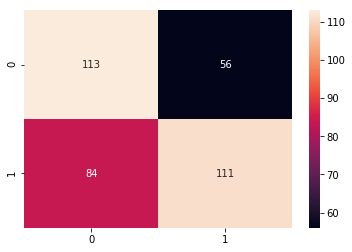

In [351]:
# confusion matrix
cm_lib = confusion_matrix(df_liberal['sentiment'],df_liberal['prediction'])
sns.heatmap(cm_lib,annot=True,fmt='d')
plt.show()

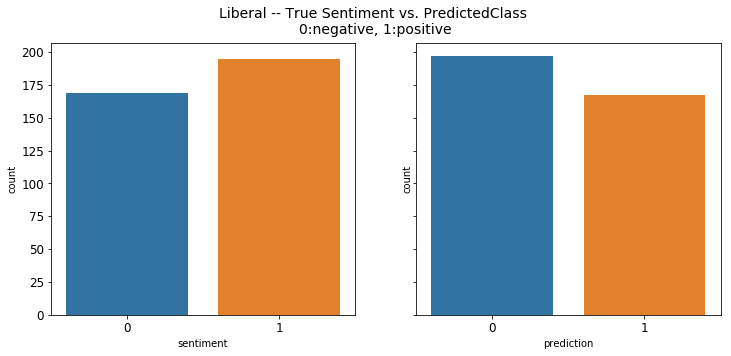

In [352]:
# Prediction VS True for Liberal
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Liberal -- True Sentiment vs. PredictedClass \n0:negative, 1:positive',fontsize=14)

sns.countplot(x='sentiment', data=df_liberal,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_liberal,ax=ax2).tick_params(labelsize=12)

#### Conservative

In [353]:
df_conser = df_party[df_party['political_party']=='conservatives']
df_conser.head()

,sentiment,prediction,political_party
0,0,1,conservatives
2,0,0,conservatives
7,0,0,conservatives
8,0,0,conservatives
13,1,0,conservatives


In [354]:
acc_conser = accuracy_score(df_conser['sentiment'],df_conser['prediction'])
print("Accuracy of Conservative Party: {}%".format(round(acc_conser*100,2)))

Accuracy of Conservative Party: 61.81%


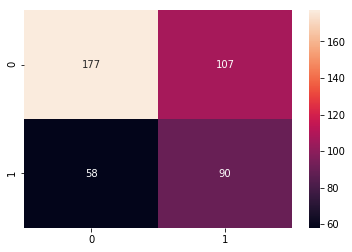

In [355]:
cm_conser = confusion_matrix(df_conser['sentiment'],df_conser['prediction'])
sns.heatmap(cm_conser,annot=True,fmt='d')
plt.show()

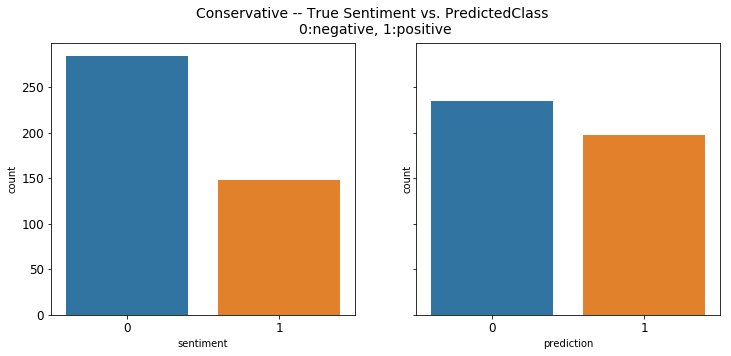

In [356]:
# Prediction VS True for Conservative
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Conservative -- True Sentiment vs. PredictedClass \n0:negative, 1:positive',fontsize=14)

sns.countplot(x='sentiment', data=df_conser,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_conser,ax=ax2).tick_params(labelsize=12)

#### New Democratic

In [357]:
df_ndp = df_party[df_party['political_party']=='new democratic party']
df_ndp.head()

,sentiment,prediction,political_party
23,0,1,new democratic party
25,1,1,new democratic party
80,1,0,new democratic party
97,1,1,new democratic party
102,1,1,new democratic party


In [358]:
acc_ndp = accuracy_score(df_ndp['sentiment'],df_ndp['prediction'])
print("Accuracy of Conservative Party: {}%".format(round(acc_ndp*100,2)))

Accuracy of Conservative Party: 55.79%


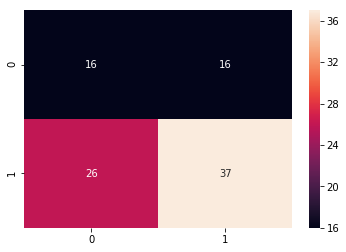

In [359]:
cm_ndp = confusion_matrix(df_ndp['sentiment'],df_ndp['prediction'])
sns.heatmap(cm_ndp,annot=True,fmt='d')
plt.show()

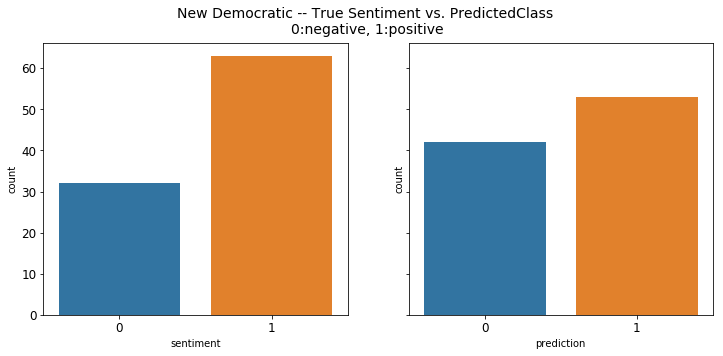

In [360]:
# Prediction VS True for NDP
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('New Democratic -- True Sentiment vs. PredictedClass \n0:negative, 1:positive',fontsize=14)

sns.countplot(x='sentiment', data=df_ndp,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='prediction', data=df_ndp,ax=ax2).tick_params(labelsize=12)

## Part 3. Multiclass Classifications on Negative Reasons

**Procedure:**
1. Extract the tweets labelled with 'Negative' Sentiment
2. Combine similar reasons to categorize and encode them with numerical values
3. Apply the Term Frequency-Inverse Document Frequency (TFIDF) method to create numerical features
4. Choose the 3 algorithms based on types normal machine learning model, probabilistic model and ensemble

**Results:** <br>

|Model|Train Accuracy|Test Accuracy|
|-----|----- --------|---- --------|
|Logistic regreesion| 99.72% |66.23%|
|Naive Bayes| 93.47% |60.26%|
|Random Forest| 97.16% | 67.88%|

In [361]:
#extract negative sentiment
df_reason = df_election[df_election['sentiment'] == 0]

In [363]:
df_reason.index = range(len(df_reason))

In [365]:
df_reason.head()

,sentiment,negative_reason,text,political_party
0,0,Women Reproductive right and Racism,instead suggestion agree canadian woman trust ...,conservatives
1,0,Economy,brantford going cost 94 billion next 4 year as...,liberal
2,0,Economy,canada taxpayer sick tired hard earned donated...,None
3,0,Others,canadavotes2019 elxn43 cdnpoli fact blastfromt...,conservatives
4,0,Others,chooseforward cdnpoli elxn43canada make americ...,liberal


In [367]:
df_reason.drop(['sentiment','political_party'],axis=1,inplace=True)

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [369]:
df_reason['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

#### Categorize negative reasons

   * Personal: Scandal, Tell lies, Privilege, Separation
   * economic: Economy
   * Political: Women Reproductive right and Racism, Climate Problem, Healthcare, Healthcare and Marijuana
   * Others: others
   
I splitted the reasons into four categories as personal reasons, economic reasons, political reasons and others since these are the sources of major types of negative reasons.

Considering the negative reason prediction is a multiclass problem and the one-vs-rest (or one-vs-all) classifier concept will be applied here. The strategy will do binary logistic regression multiple times, i.e. regard one class as 0 and all other classes as 1. The module will be directly imported from sklearn.

In [370]:
df_reason['negative_reason'].replace(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem','Healthcare', 'Separation', 'Healthcare and Marijuana']
                                    ,[2,1,3,0,0,0,2,2,0,2],inplace=True)

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [372]:
df_reason.head()

,negative_reason,text
0,2,instead suggestion agree canadian woman trust ...
1,1,brantford going cost 94 billion next 4 year as...
2,1,canada taxpayer sick tired hard earned donated...
3,3,canadavotes2019 elxn43 cdnpoli fact blastfromt...
4,3,chooseforward cdnpoli elxn43canada make americ...


#### Prepare Dataset by transforming by TFIDF

In [373]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
array_TFIDF_reason = tfidf.fit_transform(df_reason['text'])

In [374]:
# Split into train and test dataset
Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r = train_test_split(array_TFIDF_reason, df_reason['negative_reason'],test_size=0.3,stratify=df_reason['negative_reason'])

#### Make Predictions and Visualize the Results

In [414]:
#accuracy of TF-IDF model
def get_reason_accuracy(model, X_train, X_test, y_train, y_test):
    
    dic = {'lr':'Logistic Regression',
          'nb':'Naive Bayes',
          'rf':'Random Forest'}
    
    train_acc, test_acc = [], []
    
    if model == 'lr':
        clf = OneVsRestClassifier(LogisticRegression(C=0.01, solver='liblinear',multi_class='ovr'))
    elif model == 'nb':
        clf = OneVsRestClassifier(MultinomialNB(alpha=20))
    elif model == 'rf':
        clf = OneVsRestClassifier(RandomForestClassifier(max_depth=200,min_samples_split=20))
    else:
        print('Model doesn\'t exist')

    clf.fit(X_train, y_train)

    # predict using train data
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # predict using test data
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)   
 
    print("Model: ", dic[model])
    print("\nTraining accuracy is: {}%".format(round(train_acc*100,2)))
    print("\nTest accuracy is: {}%".format(round(test_acc*100,2)))
    
    return round(train_acc*100,2), round(test_acc*100,2)

In [415]:
train_acc_lr, test_acc_lr = get_reason_accuracy('lr',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

Model:  Logistic Regression

Training accuracy is: 99.72%

Test accuracy is: 66.23%


In [416]:
train_acc_nb, test_acc_nb = get_reason_accuracy('nb',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

Model:  Naive Bayes

Training accuracy is: 94.6%

Test accuracy is: 60.93%


In [417]:
train_acc_rf, test_acc_rf= get_reason_accuracy('rf',Xidf_train_r, Xidf_test_r, yidf_train_r, yidf_test_r)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\barry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model:  Random Forest

Training accuracy is: 97.16%

Test accuracy is: 67.88%


In [418]:
pd.DataFrame([[train_acc_lr,train_acc_nb,train_acc_rf],
              [test_acc_lr,test_acc_nb,test_acc_rf]],index=['Training Accuracy','Test Accuracy'],columns=['Logistic Regression',
                                                                                                         'Naive Bayes','Random Forest'])

,Logistic Regression,Naive Bayes,Random Forest
Training Accuracy,99.72,94.60,97.16
Test Accuracy,66.23,60.93,67.88


## Bonus (Using Multilayer Perceptron to Predict Negative Reasons, with Hyper Parameter Tuning)

Deep learning method takes a long time to train with cross-validation but it does not get a higher accuracy as I expected but it is worth to have a try.

In [467]:
from sklearn.neural_network import MLPClassifier

In [469]:
clf_mlp = MLPClassifier()
parameters = {'activation':['logistic', 'tanh', 'relu'],
             'alpha':[0.0001,0.01,0.1,0.5,1],
             'learning_rate':['constant', 'invscaling', 'adaptive']}

clf = GridSearchCV(clf_mlp, parameters, cv=5, n_jobs=-1)
clf.fit(Xidf_train_r, yidf_train_r)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

C:\Users\barry\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best cross-validation score: 59.23%
The best parameter:
 {'activation': 'tanh', 'alpha': 0.5, 'learning_rate': 'constant'}


In [471]:
clf_mlp = MLPClassifier(activation='tanh',alpha=0.5,learning_rate='constant')
clf_mlp.fit(Xidf_train_r, yidf_train_r)
pred_mlp = clf.predict(Xidf_test_r)
test_acc = accuracy_score(yidf_test_r, pred_mlp)
print("\nTest accuracy is: {}%".format(round(test_acc*100,2)))


Test accuracy is: 63.91%


# 5.0 Discussion

### 5.1 Sentiment Analysis Discussion

- Based on the visualizations of true sentiment values for all three parties in the above section, we can clearly see that for Conservative party, the number of negative reasons are almost doubled the number of positive sentiments which indicates it has few supportors from the public view; for liberal party, positive and negative sentiments are almost evenly distributed which means the public views this party fairly and no bias is induced; for NDP, it's opposite to the conservative party since it has positive sentiments doubled over negative ones which means NDP gets more suportors in twitter and public view it more positively.


- In the sentiment prediction of the Canadian election dataset, the model with best performance is the logistic regression using the TF-IDF vectorization and it provides an accuracy of 66.23%. After plotting out the true sentiment and predicted sentiment for each of the 3 main political parties, we can see the model generally over-predict the negative sentiment and under-predict the positive sentiment for both Liberal and NDP, however, the opposite happens for the Conservative Party. The reason may be the number of negative sentiment for Conservative party is almost doubled the positive sentiment in the true distribution, this may induce some bias in the model so that it tends to regard some positive sentiment to negative one. Same reason could be applied to the Liberal and NDP where positive sentiments are much more than negative ones.


- **What can public opinion on twitter tells us about the Canadain political Landscape in 2019?**
In reality the positive and negative comments are evenly distributed for the Liberal while the negative sentiment takes up the majority for the Conservative Party. The prediction results will provide wrong public opinions to both of the parties since more negative sentiments are induced to the Liberal and fewer negative ones to the Conservative party which are both opposite to reality. In contrast, the relatively well predicted sentiment results for the NDP will get the actual public voice better and more accurate. The majority of the NDP tweets holds the positive sentiment, suggesting that although the it is not a popular political party in the 2019 election, the NDP actually holds a pretty good public support.


- When exploring the relationship between the true sentiment and winner Party, one thing is clear that the political parties that have been mentioned most in social platforms are definitely the popular parties such as the Liberal Party and Conservative Party, which are the two strong competitors in the 2019 election. And considering the more negative public opinions on the Conservative Party in the tweets, the Liberal Party seems to be more likely to win, and this matches with the election outcomes as well. Also, analyzing the reasons behind the negative sentiment can help political parties to take future actions accordingly in the election campaigns.


- We can see that logistic regression model achieved a lower accuracy on the election dataset, this may be due to insufficient amount of data points are in the election tweets. Compared with the model performance on the generic sentiment dataset which contains a total of almost 130000 observations with negative and positive snetiments evenly distributed as we discussed in the exploratory analysis, the election dataset only includes about 2100 data points and has more positive sentiments than negative ones.



- Ways to improve:
One of the improvements in the logistic regression model could be to decrease the number of features to reduce overfitting, the best model from sentiment tweets has 57000 features and election tweets only have 6700 features, the model achieved a very high training accuracy and low test accuracy in the end.

### 5.2 Negative Reason Prediction Discussion

Based on the results of the three selected models for the negative reason prediction, the model with best performance is random forest Model since it provides the best overall accuracy on the testset. All three models presents a significant overfitting problem since the training accuracy is obviously much higher than the test accuracy. One of the reasons of bad performance could also be the insufficient amount of the dataset for the model since we only have 700 training examples to train the model and it may not be enough for a multiclass-classification problem. Also, for the number of negative reasons (pie chart in the EDA part), we can see some of the reasons such as 'privilege', 'economics'  and 'healthcare' only have tiny proportions among all other reasons and may make the model biased to the majority class.

- Ways to improve: 
    - Collect more data or better feature selection. Currently we only have around 1000 records however by checking X_test we have over 5000 features genereated. This makes the model trained only specific to the train set. If we have as much as data in generic tweets, the model will perform much better.
    - Collect more details on the negative reasons and try to make it balanced. Elaborate more details on the 'other' type may be better.
    - Reduce the number of features may help to reduce overfitting.

#### Example of Wrong Prediction

Choosing 551 as an example, we can see clearly the negative reason is about economic issues, however, the model classified it as personal reasons. The reason behind may be class 1 has no enough training data to the model, but class 0 almost occupies half of the data.

In [443]:
clf = OneVsRestClassifier(LogisticRegression(C=0.01, solver='liblinear',multi_class='ovr'))
clf.fit(Xidf_train_r, yidf_train_r)
# predict using test data
pred_lr = clf.predict(Xidf_test_r)
test_acc = accuracy_score(yidf_test_r, pred_lr)

In [455]:
pd.DataFrame([pred_lr,yidf_test_r],index=['Prediction','True'],columns=yidf_test_r.index)

,15,503,551,278,252,595,912,478,164,352,...,860,599,411,160,488,400,738,838,350,794
Prediction,0,0,0,0,0,0,0,3,0,3,...,0,3,0,0,0,3,0,0,3,2
True,0,0,1,0,0,1,3,3,0,3,...,0,3,0,1,0,0,3,0,0,2


In [453]:
df_reason.loc[551,'text']

'one said theyld ramp 80 billion dollar debt four year either trudeau actually promised 1 billion dollar deficit he promising additional 100 billion dollar debthe bankrupt canada cdnelxn2019 elxn43'

In [464]:
#personal reasons
len(df_reason[df_reason['negative_reason']==0])

496

In [463]:
#economic reasons
len(df_reason[df_reason['negative_reason']==1])

51